In [1]:
# Code author: Yuan Gong
# Email: yuangong@mit.edu
# Institution: Massachusetts Institute of Technology
# Date: 04/26

# Data Author: Yuanchao Li
# Email: yuanchao.li@ed.ac.uk
# Institution: University of Edinburgh
# Date: 04/26

# ! pip install openai
# ! pip install matplotlib seaborn scikit-learn
# ! pip install tenacity

import csv
import os
import json
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import time
from openai import OpenAI

# use your openai key
key = 'sk-'

In [2]:
file_path = 'F:\\SLT_2024\\train_ensemble\\combined\\combined.json'

# Open the JSON file and load its contents into a Python dictionary
with open(file_path, 'r') as file:
    data = json.load(file)

# Organize data by session and script
session_script_dict = {}

for item in data:
    parts = item['id'].split('_')
    session_id = parts[0]
    script_id = '_'.join(parts[1:-1])  # Join all parts between session ID and the last part
    if session_id not in session_script_dict:
        session_script_dict[session_id] = {}
    if script_id not in session_script_dict[session_id]:
        session_script_dict[session_id][script_id] = []
    session_script_dict[session_id][script_id].append(item)

# List the sessions in the training data
print('Sessions in the data:')
print(list(session_script_dict.keys()))

# Print a sample entry of the first session and script
first_session = list(session_script_dict.keys())[0]
first_script = list(session_script_dict[first_session].keys())[0]

print('-------------\nA sample entry:')
for key, value in session_script_dict[first_session][first_script][0].items():
    print(f"{key}: {value}")

Sessions in the data:
['Ses01F', 'Ses01M', 'Ses02F', 'Ses02M', 'Ses03F', 'Ses03M', 'Ses04F', 'Ses04M', 'Ses05F', 'Ses05M']
-------------
A sample entry:
need_prediction: no
emotion: fru
id: Ses01F_script01_1_F000
speaker: Ses01_F
groundtruth: What's he going to say?
hubertlarge: what's he ging to say
w2v2100: what's he gen to say
w2v2960: what's he going to say
w2v2960large: what's he going to say
w2v2960largeself: what's he going to say
wavlmplus: whats he gon to say
whisperbase: What's he gonna say?
whisperlarge: What's he gonna say?
whispermedium: What's he gonna say?
whispersmall: What's he gonna say?
whispertiny: What's he gonna say?
ensemble: What's he going to say?


In [3]:
client = OpenAI(api_key='sk-')
log = []


@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def gpt_request(**kwargs):
  return client.chat.completions.create(**kwargs)

# predict the emotion of a sentence considerating the conversation context, using gpt-3.5-turbo based on whisper-tiny transcription
def gpt_emotion_predictor(context, cur_input, number_of_contexts=10):
  """
  Predicts the emotional state of a speaker based on the current input sentence and the conversational context.

  Parameters:
  context (list of dict): A list of dictionaries, each representing a previous conversational turn. Each dictionary
                          should contain at least the keys 'speaker' and 'sentence' indicating who the speaker was
                          and what they said, respectively.
  cur_input (dict): A dictionary representing the current sentence to be analyzed. It should contain at least the keys
                    'speaker' and 'sentence', similar to the dictionaries in `context`.
  number_of_contexts (int, optional): The number of contextual entries to consider for emotion prediction. Defaults to 3. The more context, the more expensive.

  Returns:
  str: The predicted emotion for the current sentence, from a set of predefined emotions such as 'happy', 'sad',
        'neutral', or 'angry'.
  """

  emotion_code_dict = {'happy': 'hap', 'neutral': 'neu', 'angry': 'ang', 'sad': 'sad'}
  # for simplicity, we just use whisper-tiny's transcription, feel free to use any transcription we provide, and you can combine them
  background = 'Two speakers are talking. The conversation is:\n'
  context = '\n'.join(f"{item['speaker']}: {item['ensemble']}" for item in context[-number_of_contexts:]) + '\n'
  cur_sentence = f"Now speaker {cur_input['speaker']} says: '{cur_input['ensemble']}'. \n"
  task = f"Predict the emotion of the sentence '{cur_input['ensemble']}' from the options [happy, sad, neutral, angry], consider the conversation context, do not explain, only output the label in [happy, sad, neutral, angry]."
  prompt = background + context + cur_sentence + task
  #print(prompt)
  chat_history = [{"role": "system", "content": "You are a speech emotion predictor."},
                  {"role": "user", "content": prompt}]
  response = gpt_request(
             model="gpt-4o",
             messages=chat_history).choices[0].message.content.strip().lower()
  #print('Predicted emotion:', response)
  #print('----------')
  if response not in emotion_code_dict:
    # model may still output emotion that is not in our list, project to neutral
    # print('prediction not in the options ', response)
    pred_emotion = 'neu'
  else:
    pred_emotion = emotion_code_dict[response]
  log.append([prompt, response])
  return pred_emotion

In [4]:
# Function to predict emotions for an entire script
def predict_script(script):
    num_sentence = len(script)
    emotion_ground_truth, emotion_prediction = [], []
    for i, cur_sentence in enumerate(script):
        need_pred = cur_sentence['need_prediction']
        if need_pred == 'yes':
            cur_label = cur_sentence['emotion']
            cur_context = script[0:i]
            try:
                time.sleep(0.1)
                cur_pred = gpt_emotion_predictor(cur_context, cur_sentence)
                emotion_ground_truth.append(cur_label)
                emotion_prediction.append(cur_pred)
            except Exception as e:
                print('openai api has an error.', e)
                emotion_ground_truth.append('neu')
                emotion_prediction.append('neu')
        # Log the prediction
        log_entry = {
            'id': cur_sentence['id'],
            'groundtruth': cur_label if need_pred == 'yes' else None,
            'prediction': cur_pred if need_pred == 'yes' else None,
            'error': str(e) if 'e' in locals() else None
        }
        log.append(log_entry)
    return emotion_ground_truth, emotion_prediction

# Predict for all scripts
all_ground_truth, all_pred = [], []
for session in session_script_dict:
    for script in session_script_dict[session]:
        # Predictions for each script
        print('session:', session, 'script:', script)
        emotion_ground_truth, emotion_prediction = predict_script(session_script_dict[session][script])
        print('# ground truth emotion', len(emotion_ground_truth), '# predicted emotion', len(emotion_prediction))
        # Concatenate predictions of all scripts
        all_ground_truth += emotion_ground_truth
        all_pred += emotion_prediction

csv.writer(open('F:\\SLT_2024\\train13\\pred.csv', 'w', newline='')).writerow(all_pred)
csv.writer(open('F:\\SLT_2024\\train13\\truth.csv', 'w', newline='')).writerow(all_ground_truth)
json.dump(log, open('F:\\SLT_2024\\train13\\log.json', 'w'), indent=4)

session: Ses01F script: script01_1
# ground truth emotion 27 # predicted emotion 27
session: Ses01F script: script01_2
# ground truth emotion 15 # predicted emotion 15
session: Ses01F script: script01_3
# ground truth emotion 51 # predicted emotion 51
session: Ses01F script: script02_1
# ground truth emotion 36 # predicted emotion 36
session: Ses01F script: script02_2
# ground truth emotion 45 # predicted emotion 45
session: Ses01F script: script03_1
# ground truth emotion 25 # predicted emotion 25
session: Ses01F script: script03_2
# ground truth emotion 60 # predicted emotion 60
session: Ses01M script: script01_1
# ground truth emotion 44 # predicted emotion 44
session: Ses01M script: script01_2
# ground truth emotion 14 # predicted emotion 14
session: Ses01M script: script01_3
# ground truth emotion 54 # predicted emotion 54
session: Ses01M script: script02_1
# ground truth emotion 36 # predicted emotion 36
session: Ses01M script: script02_2
# ground truth emotion 57 # predicted emo

Classification Report:
               precision    recall  f1-score   support

         neu       0.40      0.67      0.50       607
         sad       0.50      0.72      0.59       475
         hap       0.86      0.20      0.32       681
         ang       0.78      0.68      0.73       814

    accuracy                           0.56      2577
   macro avg       0.64      0.57      0.53      2577
weighted avg       0.66      0.56      0.54      2577

Unweighted Accuracy: 0.5587892898719441


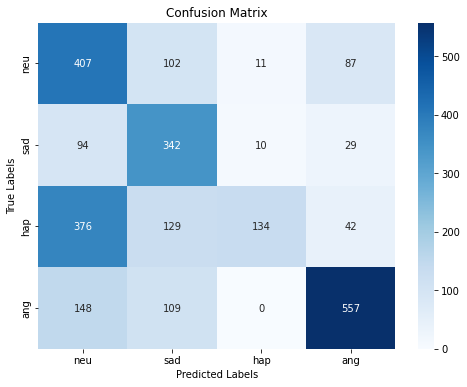

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def evaluate_emotions(emotion_ground_truth, emotion_prediction):
    """
    Calculates the unweighted accuracy and plots the confusion matrix for given lists of ground truth and predicted emotions.

    Parameters:
    emotion_ground_truth (list of str): The list of true emotion labels.
    emotion_prediction (list of str): The list of predicted emotion labels.
    """
    class_report = classification_report(emotion_ground_truth, emotion_prediction, labels=['neu', 'sad', 'hap', 'ang'])
    print("Classification Report:\n", class_report)
    # Calculate unweighted accuracy
    accuracy = accuracy_score(emotion_ground_truth, emotion_prediction)
    print(f"Unweighted Accuracy: {accuracy}")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(emotion_ground_truth, emotion_prediction, labels=['neu', 'sad', 'hap', 'ang'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['neu', 'sad', 'hap', 'ang'], yticklabels=['neu', 'sad', 'hap', 'ang'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

evaluate_emotions(all_ground_truth, all_pred)